## Plotting lesion distributions

Plotting lesion distributions for different subcohorts

Testing spatial consisitency of lesion pattern



In [29]:
#Import necessary packages
import numpy as np
from pool import matplotlib_surface_plotting as msp
import pool.paths as paths
import os
import nibabel as nb
import pandas as pd
import ptitprince as pt
import seaborn as sns
from scipy import stats
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import cm
import pool.data_loader as dl

In [2]:
#paths to filenames
lesion_file = os.path.join(paths.data_dir,'lesions.npz')
demographics_file = os.path.join(paths.data_dir,'demographics_qc.csv')

In [3]:
#load in surface mesh
verts,faces=nb.freesurfer.io.read_geometry(os.path.join(paths.BASE_PATH,
                                                        'fsaverage_sym','surf','lh.partial_inflated'))
#load in cortex label
cortex=nb.freesurfer.read_label(os.path.join(paths.BASE_PATH,
                                                 'fsaverage_sym','label','lh.cortex.label'))
# create cortex mask (i.e. exclude medial wall)
cortex_mask=np.zeros(len(verts)).astype(bool)
cortex_mask[cortex]=1

In [9]:
#load in lesions of all patients
lesions = dl.load_lesions(lesion_file)

In [10]:
#load in demographic variables for all patients
demographics = pd.read_csv(demographics_file)
#restrict demographic variables to patients with lesions masked
demographics = demographics[demographics['lesion_masked'].astype(bool)]


Plot map of all patients lesions overlayed on left hemisphere (of fsaverage_sym)
This plots where FCDs are located in our cohort

plotting


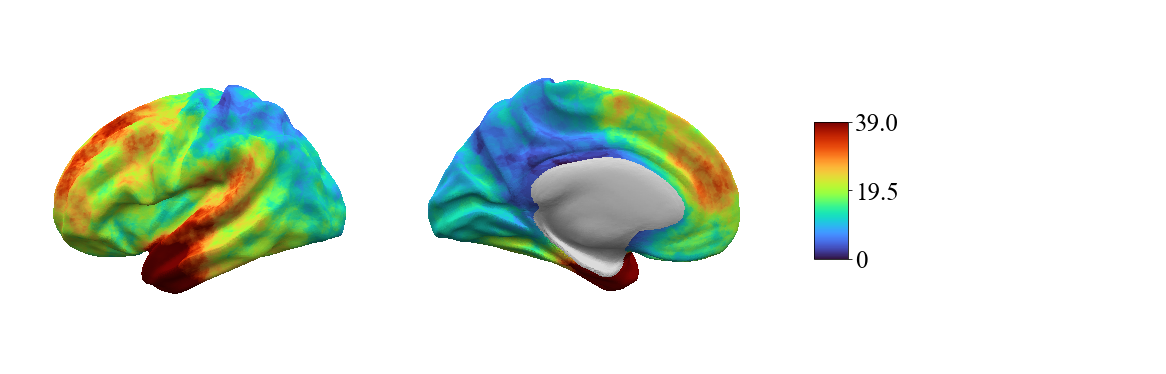

In [27]:

combined_overlay=np.sum(lesions,axis=0)
msp.plot_surf(verts,faces,combined_overlay, rotate=[90,270],
                  vmin=0,vmax=np.percentile(combined_overlay,95),
                  mask=~cortex_mask, cmap='turbo',
              pvals=np.ones(len(combined_overlay)),
                 filename=os.path.join(paths.fig_dir,'all_patients_lesion_map.png'))

plotting
plotting


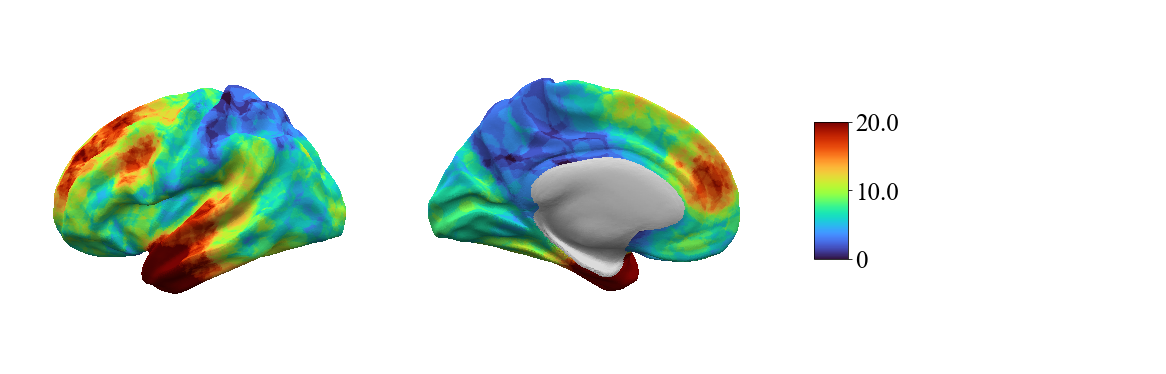

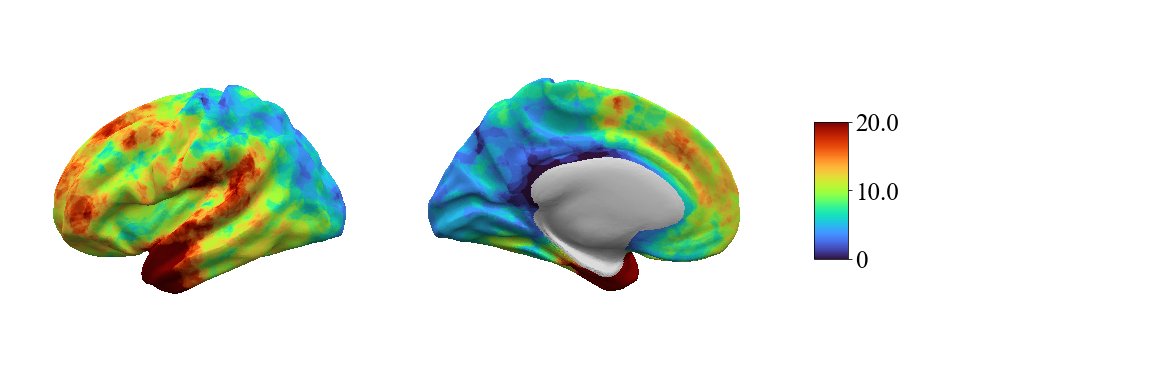

In [28]:
#plot separately for both hemispheres 
# Right hemisphere data (lower plot) plots on the left hemisphere as we are using a bilaterally symmetrical template
for hemi in ['lh','rh']:
    hemisphere_lesions = np.sum(lesions[demographics['Hemisphere']==hemi],axis=0)
    msp.plot_surf(verts,faces,hemisphere_lesions, rotate=[90,270],
                  vmin=0,vmax=np.percentile(hemisphere_lesions,95),
                  mask=~cortex_mask, cmap='turbo',
              pvals=np.ones(len(hemisphere_lesions)),
                 filename=os.path.join(paths.fig_dir,'all_patients_lesion_map_{}.png'.format(hemi)))

In [13]:
import scipy.stats as st
#check if significant difference between lesion map in this operated vs non-operated
no_surgery_overlay=np.sum(lesions[demographics['Surgery']==0],axis=0)
surgery_overlay=np.sum(lesions[demographics['Surgery']==1],axis=0)
print(st.spearmanr(no_surgery_overlay[cortex],surgery_overlay[cortex]))
diff = no_surgery_overlay.argsort().argsort()-surgery_overlay.argsort().argsort()

SpearmanrResult(correlation=0.4066760012456083, pvalue=0.0)


plotting
plotting


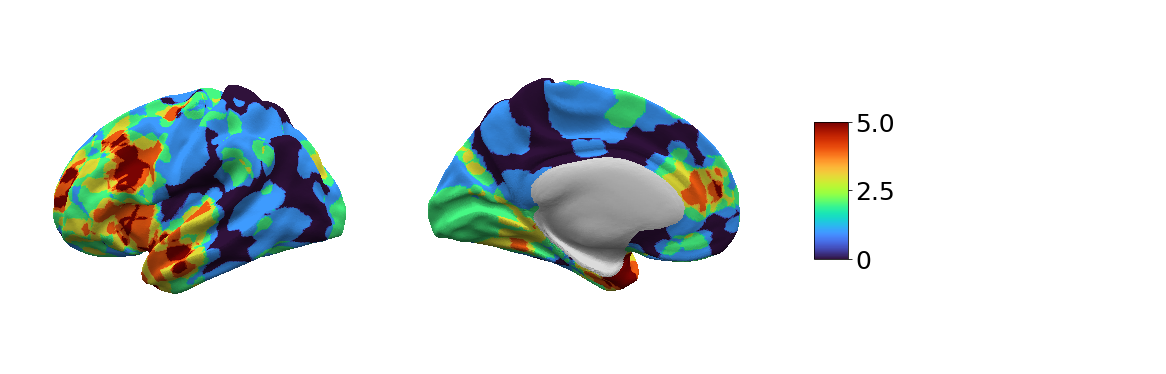

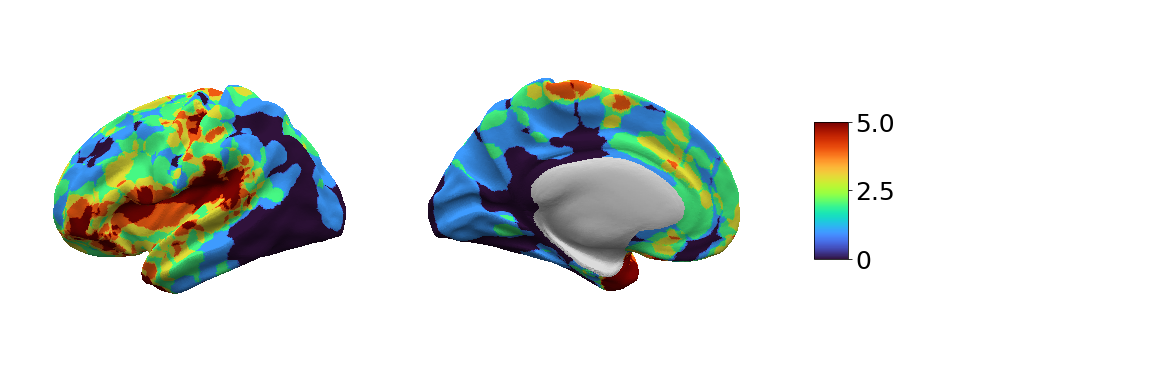

In [14]:
# Plot map of lesions in non-operated cohort
no_surgery_overlay_l=np.sum(lesions[np.logical_and(demographics['Surgery']==0,demographics['Hemisphere']=='lh')],axis=0)
no_surgery_overlay_r=np.sum(lesions[np.logical_and(demographics['Surgery']==0,demographics['Hemisphere']=='rh')],axis=0)

msp.plot_surf(verts,faces,no_surgery_overlay_l, rotate=[90,270],
                  vmin=0,vmax=np.percentile(np.hstack([no_surgery_overlay_l,no_surgery_overlay_r]),95),
                  mask=~cortex_mask, cmap='turbo',
              pvals=np.ones(len(no_surgery_overlay_l)),
                 filename=os.path.join(paths.fig_dir,'no_surgery_lesion_map_lh.png'))
msp.plot_surf(verts,faces,no_surgery_overlay_r, rotate=[90,270],
                  vmin=0,vmax=np.percentile(np.hstack([no_surgery_overlay_l,no_surgery_overlay_r]),95),
                  mask=~cortex_mask, cmap='turbo',
              pvals=np.ones(len(no_surgery_overlay_r)),
                 filename=os.path.join(paths.fig_dir,'no_surgery_lesion_map_rh.png'))

plotting
plotting


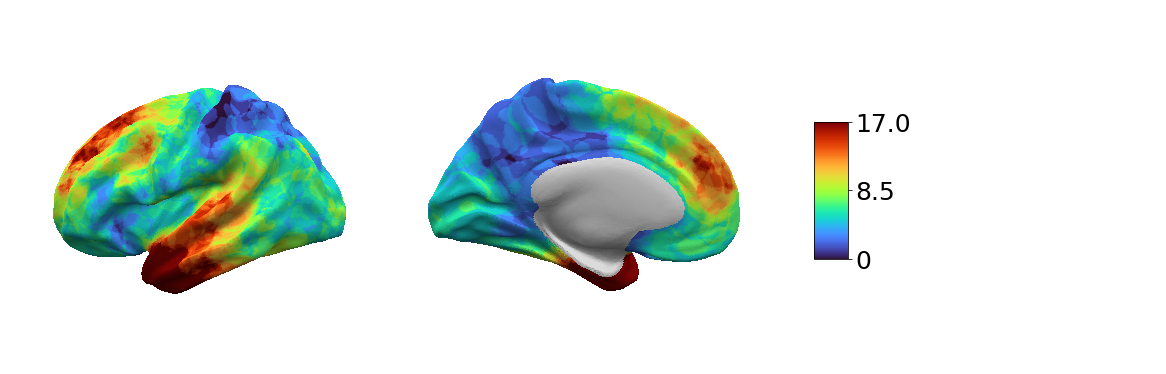

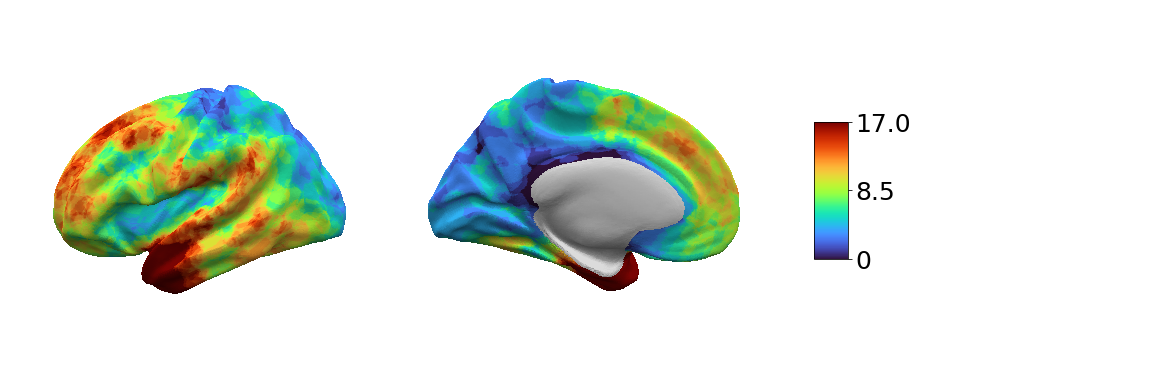

In [15]:
# plot map of lesions in operated cohort
surgery_overlay_l=np.sum(lesions[np.logical_and(demographics['Surgery']==1,demographics['Hemisphere']=='lh')],axis=0)
surgery_overlay_r=np.sum(lesions[np.logical_and(demographics['Surgery']==1,demographics['Hemisphere']=='rh')],axis=0)

msp.plot_surf(verts,faces,surgery_overlay_l, rotate=[90,270],
                  vmin=0,vmax=np.percentile(np.hstack([surgery_overlay_l,surgery_overlay_r]),95),
                  mask=~cortex_mask, cmap='turbo',
              pvals=np.ones(len(surgery_overlay_l)),
                 filename=os.path.join(paths.fig_dir,'surgery_lesion_map_lh.png'))
msp.plot_surf(verts,faces,surgery_overlay_r, rotate=[90,270],
                  vmin=0,vmax=np.percentile(np.hstack([surgery_overlay_l,surgery_overlay_r]),95),
                  mask=~cortex_mask, cmap='turbo',
              pvals=np.ones(len(surgery_overlay_r)),
                 filename=os.path.join(paths.fig_dir,'surgery_lesion_map_rh.png'))

plotting


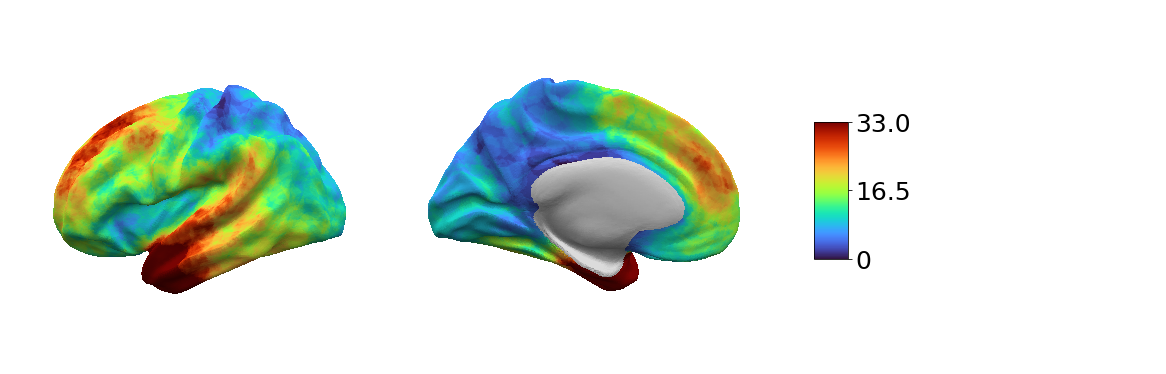

In [16]:
msp.plot_surf(verts,faces,surgery_overlay, rotate=[90,270],
                  vmin=0,vmax=np.percentile(surgery_overlay,95),
                  mask=~cortex_mask, cmap='turbo',
              pvals=np.ones(len(surgery_overlay)),
                 filename=os.path.join(paths.fig_dir,'lesion_map_surgery.png'))

plotting


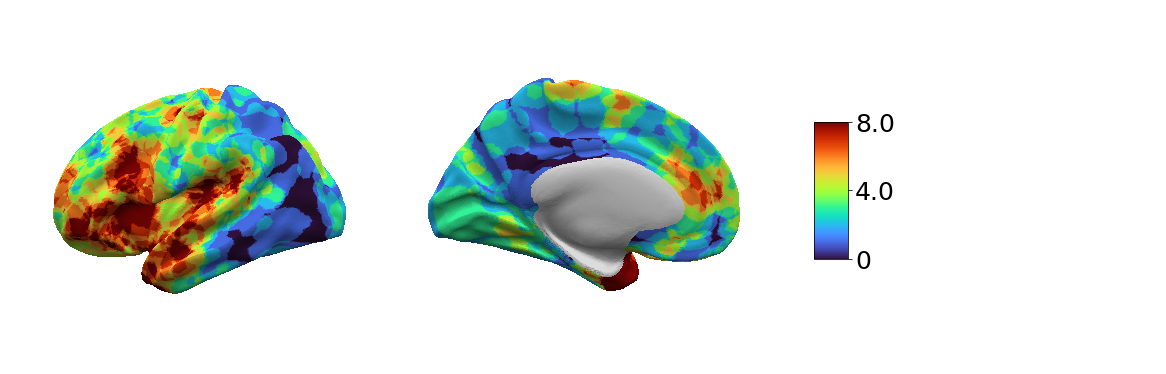

In [17]:
#PLOT no surgery
no_surgery_overlay=np.sum(lesions[demographics['Surgery']==0],axis=0)
msp.plot_surf(verts,faces,no_surgery_overlay, rotate=[90,270],
                  vmin=0,vmax=np.percentile(no_surgery_overlay,95),
                  mask=~cortex_mask, cmap='turbo',
              pvals=np.ones(len(no_surgery_overlay)),
                 filename=os.path.join(paths.fig_dir,'lesion_map_no_surgery.png'))

plotting
plotting
plotting
plotting


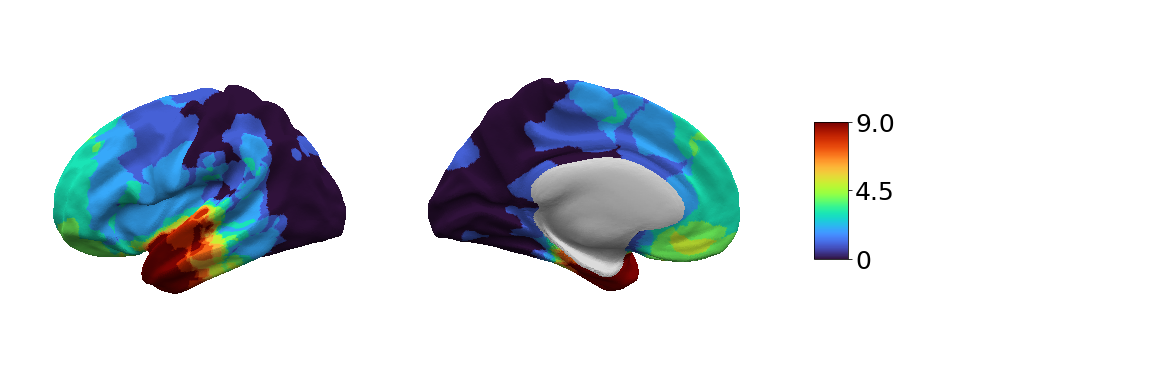

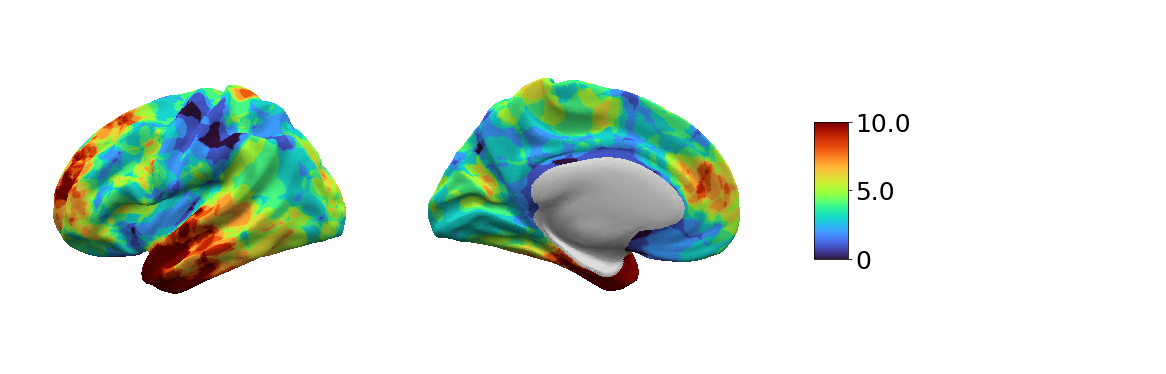

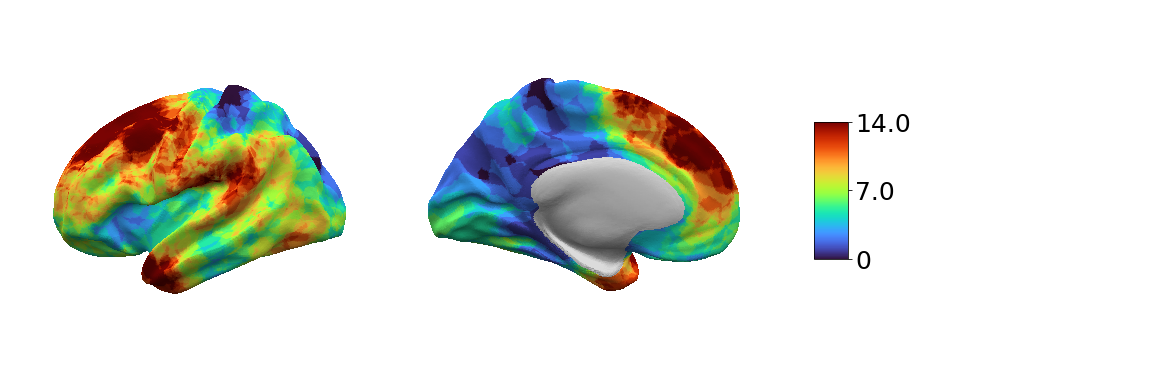

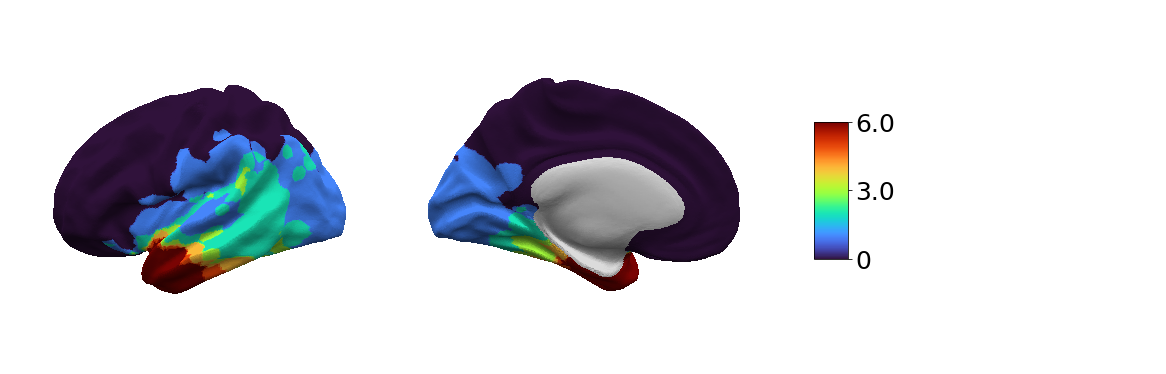

In [18]:
# Plot lesion map of all FCD 1 patients, then FCD 2A, then 2B and then FCD 3 patients 
# This is to look at how the distribution / topography of lesions differs across histological subtypes
for histology in ['1','2A','2B','3']:
    histology_overlay=np.sum(lesions[demographics['Histology']=='FCD_{}'.format(histology)],axis=0)
    msp.plot_surf(verts,faces,histology_overlay, rotate=[90,270],
                  vmin=0,vmax=np.percentile(histology_overlay,95),
                  mask=~cortex_mask, cmap='turbo',
              pvals=np.ones(len(histology_overlay)),
                 filename=os.path.join(paths.fig_dir,'lesion_map_FCD_{}.png'.format(histology)))

In [19]:
#Define functions needed for experiment to look at how sample size affect the lesion map.

def permute(n):
    return np.random.permutation(n)

def rank_vector(vector):          
    temp = vector.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(vector))
    return ranks

def func(x, a,b, c):
    return (1-a)-b*x**c #+b-(b-0)*np.exp(-d*x)

In [20]:
#This is an experiment to look at how sample size affect the lesion map.
# Different cohorts of the following sizes (20, 40, 60 .. 250) are created 1000 times (1000 iterations)
# The locations of the lesions in each random cohort are compared to a lesion map of 250 patients
# The correlation coefficients for each of the 1000 iterations of each cohort size are stored
lesions=np.load(os.path.join(paths.data_dir,'lesions_smoothed.npy'))
n_iter=1000
cohort_sizes=[20,40,60,80,100,150,200,250]
#full_cohort = np.sum(lesions,axis=0)

r_n_values = [] #np.zeros((len(cohort_sizes),n_iter))

for n in np.arange(n_iter):
    bool_i=np.zeros(len(lesions),dtype=bool)

    #randomly shuffle all subjects
    indices=permute(len(lesions))
    #larger cohort of fixed size drawn
    cohort2=rank_vector(np.sum(lesions[indices[250:]],axis=0)[cortex_mask])
    for k,n_subs in enumerate(cohort_sizes):
        bool_i[indices[:n_subs]]=1
        #print(np.sum(bool_i))
        #first smaller cohort drawn
        v=np.sum(lesions[bool_i],axis=0)[cortex_mask]
        cohort1=rank_vector(v)   
        r_n_values.append([np.corrcoef(cohort1,cohort2)[0,1],n_subs]) 


In [21]:
#Create a dataframe of the cohort size and the R values
r_n_values=pd.DataFrame(r_n_values,columns=['R','n_subs'])

<AxesSubplot:xlabel='n_subs', ylabel='R'>

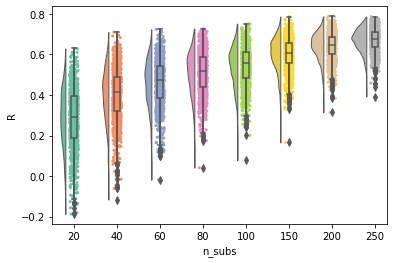

In [22]:
# Plot the R values for each sample size
pt.RainCloud(y='R',x='n_subs',data=r_n_values)

In [23]:
# Calculate mean R and std R for each subcohort size
mu=np.array(r_n_values.groupby('n_subs').mean()['R'])
std=np.array(r_n_values.groupby('n_subs').std()['R'])

In [24]:

lb,up=stats.t.interval(alpha=0.95, df=n_iter-1, loc=mu, scale=
             std) 


In [25]:
# Set different colours for each sample size
colors=cm.Set2(np.arange(len(cohort_sizes)))
my_pal={}
k=-1
for c in np.arange(251):
    if c in cohort_sizes:
        k+=1
        my_pal[c]=colors[k]
    else:
        my_pal[c]=colors[k]
        

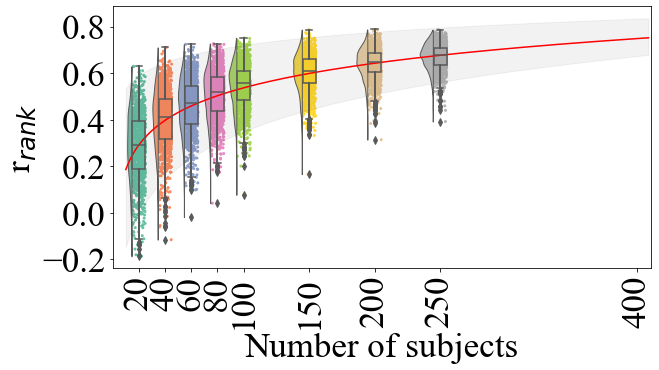

In [26]:
# Plot R values of different sample sizes
# Fit learning curve to data 
import matplotlib
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 35}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))

popt, pcov = curve_fit(func, r_n_values['n_subs'],r_n_values['R'],maxfev=10000)
x_vals=np.arange(400)+10
sigma_ab = np.sqrt(np.diagonal(pcov))
ax.plot(x_vals, func(x_vals, *popt), 'r-',)

popt, pcov = curve_fit(func, cohort_sizes,lb,maxfev=10000)
l_b=func(x_vals, *(popt))
popt, pcov = curve_fit(func, cohort_sizes,up,maxfev=10000)
u_b=func(x_vals, *(popt))
ax.fill_between(x_vals, l_b, u_b,
                 color = 'black', alpha = 0.05)
#plt.scatter(r_n_values['n_subs'],r_n_values['R'])
pt.RainCloud(y='R',x='n_subs',data=r_n_values,ax=ax,order=np.arange(251),width_viol = 20, width_box = 10,
            jitter=5,palette=my_pal)
ax.set_xlim([0,411])
ax.set_xticks(cohort_sizes+[400])
ax.set_xticklabels(cohort_sizes+[400],rotation=90,ha='center')

ax.set_xlabel('Number of subjects')
ax.set_ylabel('r$_{rank}$')
ax.set_yticks([-0.2,0.0,0.2,0.4,0.6,0.8])
plt.tight_layout()
fig.savefig(os.path.join(paths.fig_dir,'pattern_consitency_cohorts.pdf'),)
fig.savefig(os.path.join(paths.fig_dir,'pattern_consitency_cohorts.png'))